In [1]:


import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
import seaborn as sns
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


2021-12-20 11:40:25.929441: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
data = pd.read_csv("merged_new.csv")
data['local_15min'] = pd.to_datetime(data['local_15min'])
data.drop(['leg1v', 'leg2v', 'summary', 'grid'], axis = 1, inplace = True)
train_dates = data['local_15min']

df_for = data[['solar', 'temperature', 'cloud_cover']].astype(float)
for a in df_for['solar']:
    if a < 0:
        a = 0
        
# one month as testing set
df_for_training = df_for[:-720]
df_for_testing = df_for[8240:]

In [3]:
df_for

,solar,temperature,cloud_cover
0,-0.002,25.00,0.68
1,-0.006,24.97,0.91
2,-0.005,24.93,1.00
3,-0.005,24.84,0.94
4,-0.005,24.69,0.98
...,...,...,...
8953,-0.026,40.49,1.00
8954,-0.025,40.33,1.00
8955,-0.012,40.49,1.00
8956,-0.012,40.80,1.00


In [4]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled.shape

(8238, 3)

In [5]:
trainX = []
trainY = []

n_future = 1  
n_past = 24  # Number of past hours we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)

#for i in range(n_past, len(df_for_training_scaled) - n_future +1):
#    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
#    trainY.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])

for i in range(len(df_for_training_scaled)-24):
    trainX.append(df_for_training_scaled[i:(i+24)])
    trainY.append(df_for_training_scaled[i+1:(i+24)+1])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print(trainX.shape[1])
print(trainX.shape[2])

trainX shape == (8214, 24, 3).
trainY shape == (8214, 24, 3).
24
3


In [6]:
testX = []
testY = []

#Reformat test data into a shape: (n_samples x timesteps x n_features)


for i in range(len(df_for_testing_scaled)-24):
    testX.append(df_for_testing_scaled[i:(i+24)])
    testY.append(df_for_testing_scaled[i+1:(i+24)+1])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))
print(trainX.shape[1])
print(trainX.shape[2])
input_shape=(trainX.shape[1], trainX.shape[2])
input_shape

testX shape == (694, 24, 3).
testY shape == (694, 24, 3).
24
3


(24, 3)

In [7]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()


2021-12-20 11:40:27.223915: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-20 11:40:27.224680: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-20 11:40:27.322961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-20 11:40:27.322993: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-20 11:40:27.324375: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-20 11:40:27.324450: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 3)             387       
Total params: 199,555
Trainable params: 199,555
Non-trainable params: 0
__________________________________________________

Epoch 1/50


2021-12-20 11:40:28.255750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-20 11:40:28.275348: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz
2021-12-20 11:40:29.606526: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-12-20 11:40:29.814392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


116/116 [==============================] - 4s 14ms/step - loss: 0.5418 - val_loss: 0.3032
Epoch 2/50
116/116 [==============================] - 1s 10ms/step - loss: 0.3062 - val_loss: 0.2482
Epoch 3/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2693 - val_loss: 0.2180
Epoch 4/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2499 - val_loss: 0.2072
Epoch 5/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2374 - val_loss: 0.2006
Epoch 6/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2282 - val_loss: 0.1780
Epoch 7/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2187 - val_loss: 0.1674
Epoch 8/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2142 - val_loss: 0.1775
Epoch 9/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2084 - val_loss: 0.1580
Epoch 10/50
116/116 [==============================] - 1s 10ms/step - loss: 0.2033 - val_loss: 0.1587


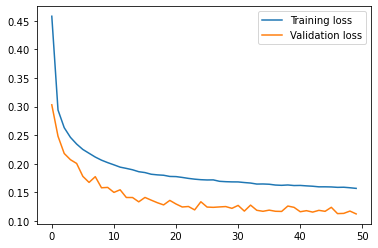

In [8]:
history = model.fit(trainX, trainY, epochs=50, batch_size=64, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

(array([[9.500e+01, 2.840e+02, 3.600e+02, 2.530e+02, 3.170e+02, 3.160e+02,
         3.320e+02, 4.040e+02, 5.930e+02, 8.340e+02, 1.244e+03, 1.307e+03,
         1.011e+03, 5.140e+02, 1.870e+02, 9.300e+01, 3.800e+01, 6.000e+00,
         3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
         4.000e+00, 4.000e+00, 0.000e+00, 4.000e+00, 3.000e+00, 4.000e+00],
        [1.700e+01, 3.260e+02, 1.064e+03, 1.742e+03, 1.781e+03, 1.514e+03,
         9.820e+02, 4.450e+02, 2.150e+02, 8.100e+01, 3.500e+01, 9.000e+00,
         2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
        [6.180e+02, 4.440e+02, 3.380e+02, 3.270e+02, 3.160e+02, 3.850e+02,
         4.740e+02, 5.920e+02, 6.590e+02, 6.820e+02, 6.560e+02, 6.580e+02,
         5.240e+02, 3.870e+02, 2.950e+02, 2.510e+02, 1.960e+02, 1.320e+02,
         7.800e+01, 4.9

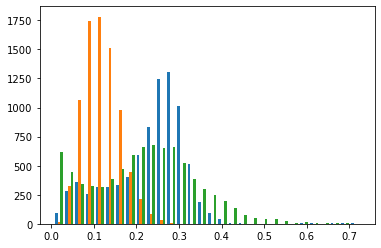

In [9]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=30)






(694, 24, 3)
(694, 24, 3)
0.3030341664566773
0.4311654965714397
0.10282813009560274


(694,)

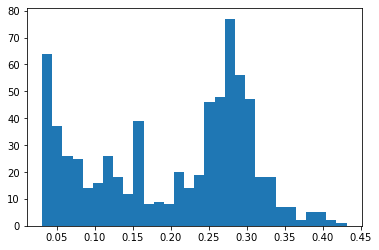

In [10]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict[:,:,0] - testX[:,:,0]), axis = 1)
plt.hist(testMAE, bins=30)
#pv_max = max(pv_an)
thor = testMAE.mean() + 1 * testMAE.std()
print(testPredict.shape)
print(testPredict.shape)
print(thor)
print(testMAE.max())
print(testMAE.std())
testMAE.shape

In [11]:
test_ori = df_for_testing_scaled[24:,0]
timestamp = train_dates[8264:]

In [12]:
error = (testPredict[:,:,0] - testX[:,:,0])

In [13]:
error

array([[-0.01168191, -0.01549487, -0.00915079, ..., -0.00144271,
        -0.00150459, -0.00177919],
       [-0.01445781, -0.01036589,  0.04237563, ..., -0.00245129,
        -0.00310343, -0.00489747],
       [-0.01230543,  0.04402263,  0.29308642, ..., -0.0042389 ,
        -0.00632828, -0.01217251],
       ...,
       [ 0.00999485,  0.00791357,  0.00374749, ...,  0.0468492 ,
         0.02826096,  0.02046127],
       [ 0.00467262,  0.00610337,  0.00220276, ...,  0.0280415 ,
         0.02120025,  0.00940981],
       [ 0.00144777,  0.00474961,  0.00312181, ...,  0.021527  ,
         0.01010308,  0.0094876 ]])

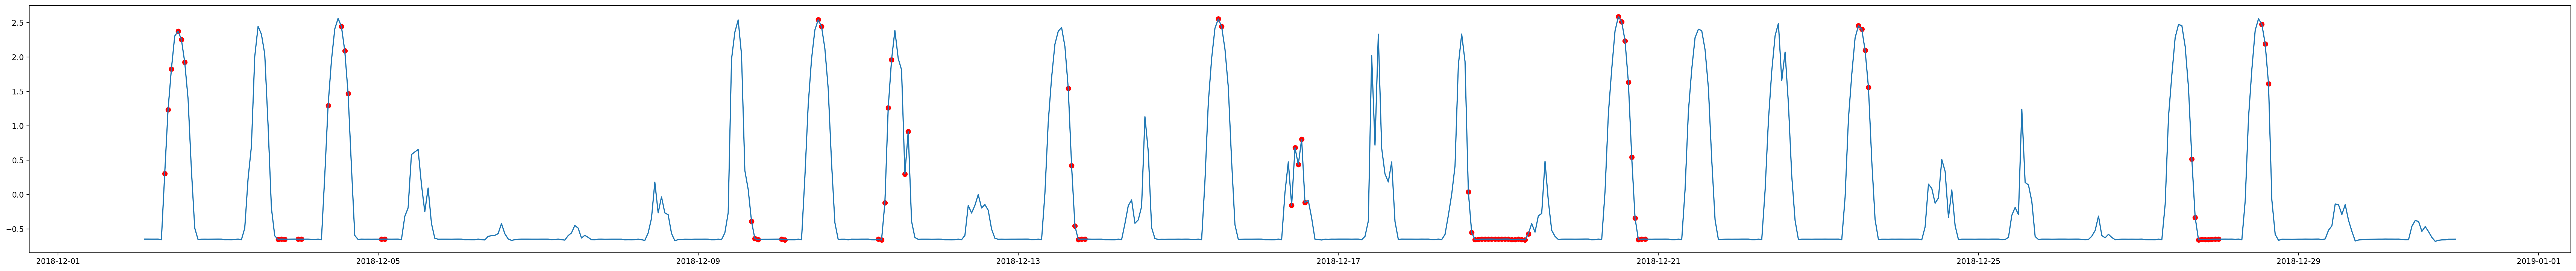

In [14]:
from matplotlib.pyplot import figure
figure(figsize=(60, 6), dpi=200)

plt.plot(timestamp, test_ori)
anolist = pd.DataFrame(
    {'data': timestamp,
     'MAE': testMAE,
     'ori': test_ori
    })

anolist_fil = anolist.loc[anolist['MAE'] > thor]

plt.scatter(anolist_fil['data'], anolist_fil['ori'], c = 'red')

In [15]:
anolist.shape

(694, 3)

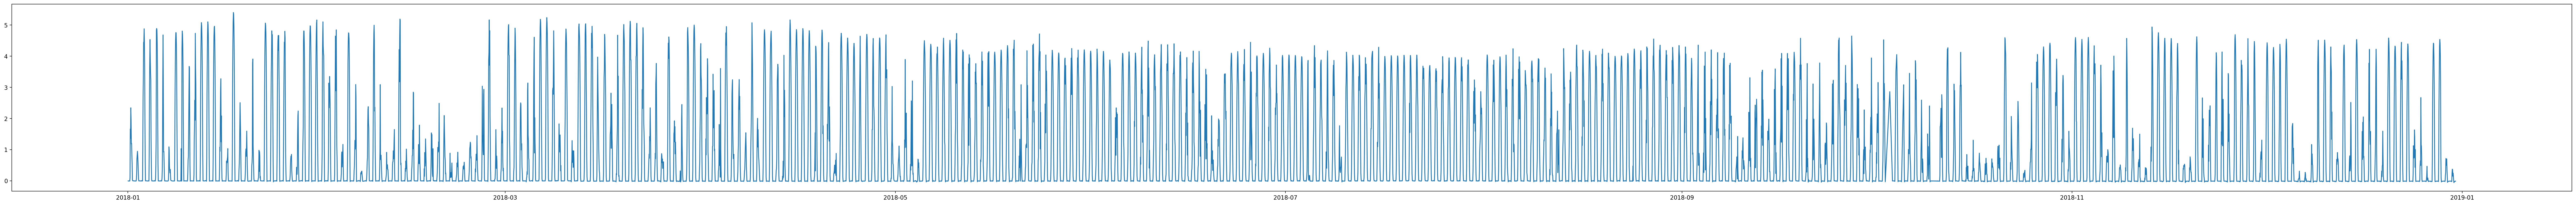

In [16]:
df_for
figure(figsize=(80, 6), dpi=200)
plt.plot(data['local_15min'], df_for['solar'])


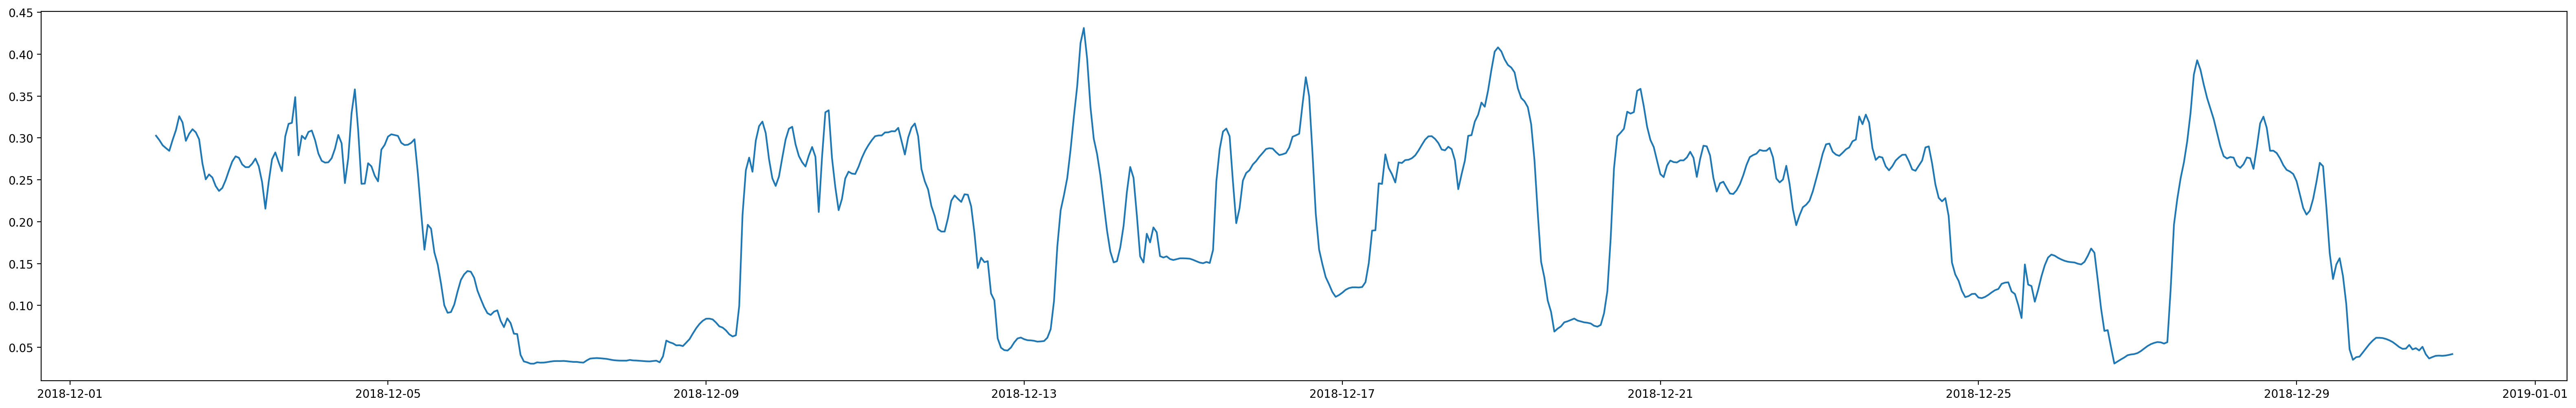

In [17]:
figure(figsize=(40, 6), dpi=200)
plt.plot(anolist['data'], anolist['MAE'])